In [34]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore
from scipy.io import wavfile

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,\
                            confusion_matrix, \
                            precision_score, \
                            recall_score, \
                            f1_score, \
                            classification_report

# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier

In [2]:
dev_path = './dev'
eval_path = './eval'

In [3]:
def load_data(data_path, phase):
    files = os.listdir(data_path)
    wav_files = [fl for fl in files if fl.endswith('.wav')]

    x = [None] * len(wav_files)
    y = [None] * len(wav_files)
    rate = [None] * len(wav_files)

    for file in wav_files:
        file_name = file.split('.')[0]
        if phase == 'dev':
            f_id, label = tuple(file_name.split('_'))
        elif phase == 'eval':
            f_id, label = file_name, float('NaN')
        else:
            raise Exception(f'Error - phase {phase} not recognised!')

        f_id, label = int(f_id), float(label)

        # wavfile.read(...) => return:
        # sr - Sample Rate
        # data - audio as array of float values

        sr, data = wavfile.read(os.path.join(data_path,file))

        x[f_id] = data.astype(np.float32)
        rate[f_id] = sr
        y[f_id] = label

    return x, y, rate

In [4]:
dev_x, dev_y, dev_sr = load_data(data_path=dev_path, phase='dev')
dev_x[:5], dev_y[:5]

([array([ 14.,  21.,   0., ...,   3., -48., -80.], dtype=float32),
  array([-2., 12.,  1., ...,  3., -3.,  3.], dtype=float32),
  array([-9., -7., -5., ..., -5., -1., -7.], dtype=float32),
  array([-256., -512.,    0., ...,    0.,    0.,    0.], dtype=float32),
  array([-20.,  10.,  26., ...,  -3.,   5., -10.], dtype=float32)],
 [4.0, 7.0, 5.0, 2.0, 3.0])

In [6]:
eval_X, _, eval_sr = load_data(eval_path, phase="eval")
eval_X[:5]

[array([   0.,    0., -512., ...,    0., -256., -256.], dtype=float32),
 array([  6.,   0.,  -3., ..., -11.,  -2., -20.], dtype=float32),
 array([-580.,  153., -668., ..., -360., -339., -343.], dtype=float32),
 array([-2., -6.,  0., ..., 23.,  9., 22.], dtype=float32),
 array([-1.,  1., -5., ...,  1., -4.,  2.], dtype=float32)]

In [8]:
# Were the audios recorded in the same conditions?
SR = dev_sr[0]
print(f"Sampling rate = {SR} [sample/s]")
print("Do the sampling rate is always the same for all the development recordings? --",
all([sr == SR for sr in dev_sr]))
print("Do the sampling rate for the evaluation set is equal to development set? --",
all([sr == SR for sr in eval_sr]))

Sampling rate = 8000 [sample/s]
Do the sampling rate is always the same for all the development recordings? -- True
Do the sampling rate for the evaluation set is equal to development set? -- True


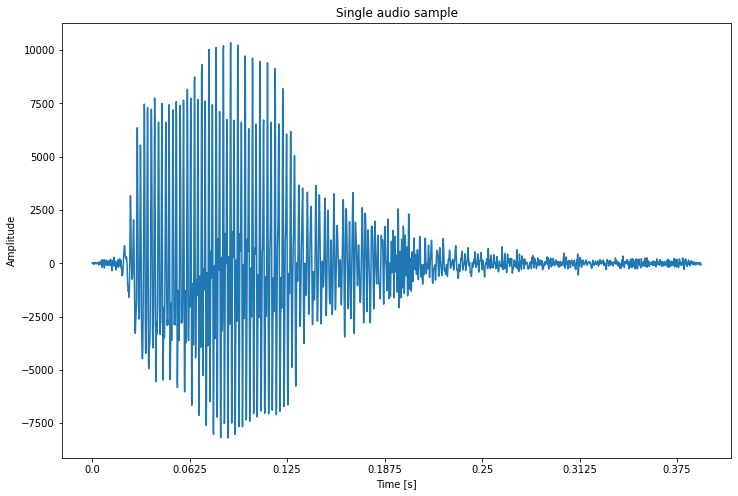

In [10]:
# With the above check we assure that the sampling rate used to record the audios is equal for all the samples.
# Thus we can plot the audio waves showing the duration of the audios in seconds

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(dev_x[0]) # Plot the first signal
# To show time on the x axes
ax.set_xticks(np.arange(0, len(dev_x[0]), 500))
ax.set_xticklabels([sample/SR for sample in np.arange(0, len(dev_x[0]), 500)])
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
ax.set_title("Single audio sample")
plt.show()

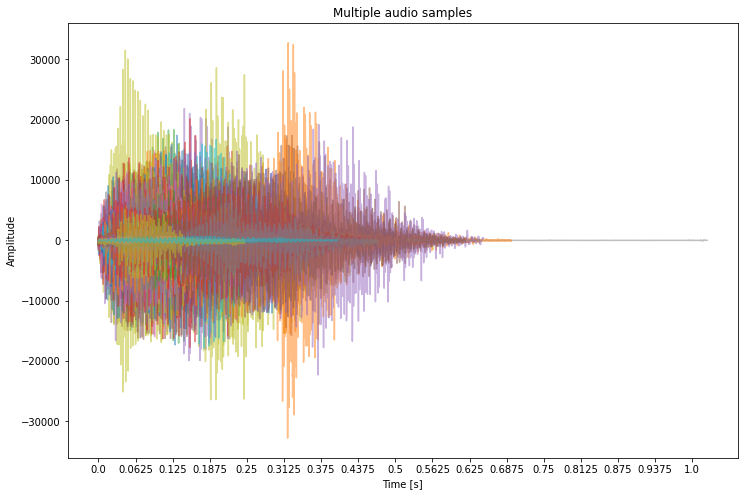

In [11]:
def plot_audio_samples(X):
    lengths = []
    fig, ax = plt.subplots(1,1,figsize=(12,8))

    for idx in range(0, len(X), 10):

        ax.plot(X[idx], alpha=0.5)
        lengths.append(len(dev_x[idx]))

        # To show time on the x axes
        ax.set_xticks(np.arange(0, max(lengths), 500))
        ax.set_xticklabels([sample/SR for sample in np.arange(0, max(lengths), 500)])

    return ax

ax = plot_audio_samples(dev_x)
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
ax.set_title("Multiple audio samples")
plt.show()

In [14]:
# From to the visualization of the audio samples it is possible to notice that the vocal samples has
# very different amplitudes in many cases. This is due to different recording conditions such as the
# sensibility of the microphone or the recording volume and so on.
# To partially overcome these issues it is possible to normalize the amplitude of each recording
# exploiting the standardization.

def normalize_data(X):
    return [zscore(x) for x in X]

dev_x = normalize_data(dev_x)
eval_x = normalize_data(eval_X)

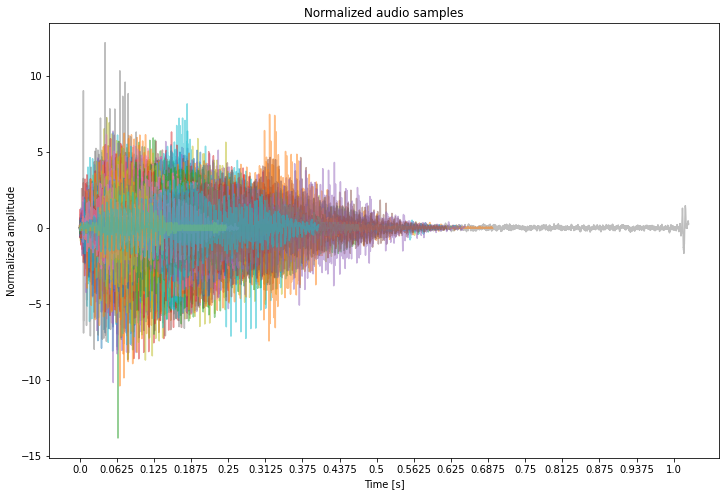

In [15]:
ax = plot_audio_samples(dev_x)

ax.set_ylabel("Normalized amplitude")
ax.set_xlabel("Time [s]")
ax.set_title("Normalized audio samples")

plt.show()

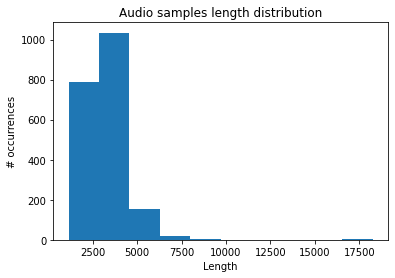

In [16]:
# Also the duration of the audios is very different. It is possible to inspect the distributions of the
# lengths in both dev and eval sets to check if any preprocessing is required.


dev_lengths = [len(x) for x in dev_x]
eval_lenghts = [len(x) for x in eval_x]

plt.hist(dev_lengths+eval_lenghts)

plt.title("Audio samples length distribution")
plt.xlabel("Length")
plt.ylabel("# occurrences")

plt.show()
plt.close()

# From the histogram above it is possible to notice that there is a small number of samples that has
# a length of around 17500. For example this can be caused by microphones left recording. These
# can be considered outliers, but, instead of removing them you can try to cut their length reaching
# the lengths of the other samples. Of course this is a problem only when dealing with analysis in
# time domain
# Cut and Pad
# To manage this problem you can consider to define an acceptable threshold length so then you can
# cut the signals longer than the threshold length and add some pad to the audio signal shorter then
# the threshold.
# Consider that the training and the prediction phase of a classifier in many cases (e.g. Rendom
# Forest) require that the data has always the same number of features. Thus, the dev and eval data
# should have the same number of features after the feature computation process.

# Cut
To choose the threshold we can inspect the percentiles of the lengths vector. In particular we want
to find a threshold that includes most of the data and leave out only the outliers. Let’s say we want
that at least the 95% of our data should have a length equal or lower than the threshold. Which
is the threshold value?

In [21]:
perc = 95

length_95_perc = int(np.ceil(np.percentile(dev_lengths+eval_lenghts, perc)))
print(f"The {perc}% of the data has length lower or equal to {length_95_perc}.")

The 95% of the data has length lower or equal to 5000.


In [22]:
'''
The np.ceil() function in Python is used to find the ceil of the elements of the array.
The numpy ceil() method accepts two arguments which are arr and out and returns the rounded value of each element.
To find the ceil of elements of the array, use the numpy ceil() method.
The ceiling value is always greater than equal to the given value.

https://appdividend.com/2020/04/10/python-numpy-ceil-function-example/
'''

'\nThe np.ceil() function in Python is used to find the ceil of the elements of the array.\nThe numpy ceil() method accepts two arguments which are arr and out and returns the rounded value of each element.\nTo find the ceil of elements of the array, use the numpy ceil() method.\nThe ceiling value is always greater than equal to the given value.\n\nhttps://appdividend.com/2020/04/10/python-numpy-ceil-function-example/\n'

In [23]:
# Thus, only 5% of data has a length higher than 5000. This is a suitable value that can be used as
# length threshold.
# Apply the cut to both dev and eval data with the threshold value previously defined.

dev_X = [x[:length_95_perc] for x in dev_x]
eval_X = [x[:length_95_perc] for x in eval_x]

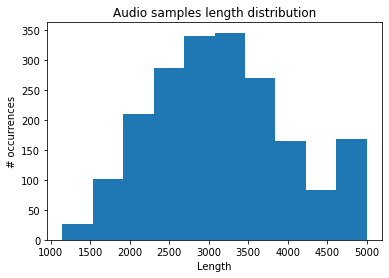

In [24]:
dev_lengths = [len(x) for x in dev_X]
eval_lenghts = [len(x) for x in eval_X]

plt.hist(dev_lengths+eval_lenghts)

plt.title("Audio samples length distribution")
plt.xlabel("Length")
plt.ylabel("# occurrences")

plt.show()
plt.close()

In [25]:
# Padding all the audio samples with zeros allows every signal to have the same length. In the case of
# audio sample, including zeros at the end of the recording has a specific meaning: since the values in
# the array are representing the amplitudes of the signal at each timestamp, the value zero represent
# the silence.

dev_X = [np.pad(x, (0,length_95_perc-len(x)), constant_values=0.0) for x in dev_X]
eval_X = [np.pad(x, (0,length_95_perc-len(x)), constant_values=0.0) for x in eval_X]

In [26]:
''''
In order to perform a windowed analysis the size of the window should be carefully analyzed. In
this specific case, the size of the window can be derived by the domain.
The paper Linguistic
uses of segmental duration in English: Acoustic and perceptual evidence highlights that in average
unstressed vowels take 70 ms while long consonants such as s can reach a duration of about 200
ms.
In this work we take in consideration a window size that is 1/5 of the maximum duration of 200 ms
to consider also short consonant and vowels. For these reasons the window size has been selected
to be equal to 40 ms and the number of the corresponding samples has been taken into account
accordingly to the sampling rate.
'''
step = int(SR * 0.04)
step

320

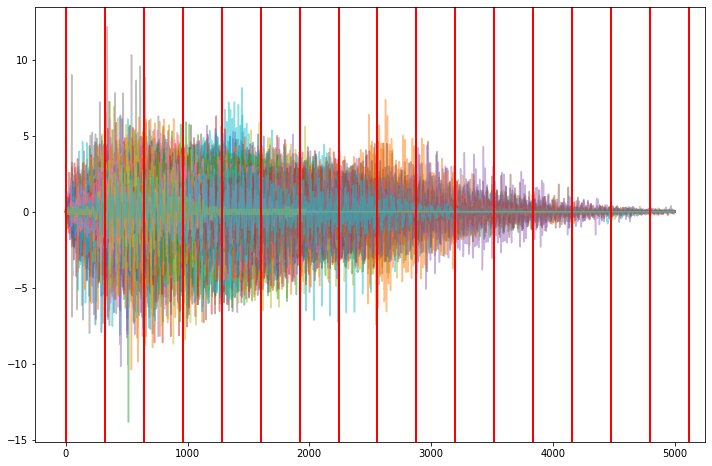

In [27]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

for idx in range(0, len(dev_X), 10):
    ax.plot(dev_X[idx], alpha=0.5)

for s in range(0,length_95_perc+step,step):
    ax.axvline(s, color="red", linewidth=2)

plt.show()
plt.close()

# Compute statistical features

After normalization phase all the audio samples has the same length. The windows size has been
specified to inspect each phonetic element. Thus, it is necessary to define the features that need to
be extracted from each window. A small set of possible features that can be calculated is: - Mean
- Standard deviation - Min value - Max value - Root mean square
Each window will be characterized by the statistics reported above. There are also many other
indexes that you can take into account to perform this analysis, the one reported above are the one
used to obtain the baseline score.

In [30]:
def RMS(a):
    return np.sqrt(np.mean(np.power(a, 2)))

def compute_signal_statistical_features(x, max_len, step):
    feat_x = []

    for idx in range(step, max_len+step, step):
        seg_x = x[idx-step:idx]
        if len(seg_x)>0:
            feat = [np.mean(seg_x),
                    np.std(seg_x),
                    np.min(seg_x),
                    np.max(seg_x),
                    RMS(seg_x)]
        else:
            feat = [0.0, 0.0, 0.0, 0.0, 0.0]

        feat_x.append(
            np.array(feat)
            )

    return np.nan_to_num(np.hstack(feat_x))

def compute_statistical_features(X, max_len, step):
    features_X = []

    for x in X:
        f_x = compute_signal_statistical_features(x, max_len, step=step)
        features_X.append(f_x)

    return np.vstack(features_X)

feat_dev_X = compute_statistical_features(dev_X, length_95_perc, step=step)
feat_dev_X.shape

(1500, 80)

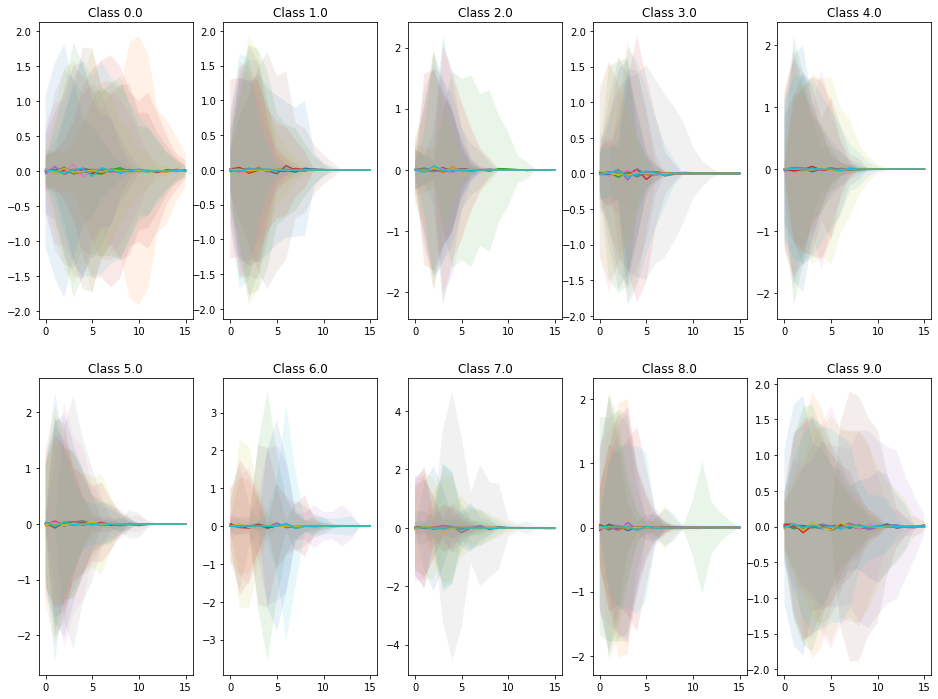

In [32]:
fig, ax = plt.subplots(2,5,figsize=(16,12))

for c in np.unique(dev_y):

    c_feat_dev_X = feat_dev_X[dev_y == c]
    idx = int(c/5)
    idy = int(c%5)

    for i in range(0,10):
        ax[idx, idy].fill_between(x= np.arange(len(c_feat_dev_X[i,0::5])),
                                y1= c_feat_dev_X[i,0::5]-c_feat_dev_X[i,1::5], # The mean minus the standard deviation
                                y2=c_feat_dev_X[i,0::5]+c_feat_dev_X[i,1::5], # The mean plus the standard deviation
                                alpha=0.1)

        ax[idx, idy].plot(c_feat_dev_X[i,0::5]) # The mean values
        ax[idx, idy].set_title(f"Class {c}")
plt.show()
plt.close()

In [33]:
feat_eval_X = compute_statistical_features(eval_X, length_95_perc, step=step)

In [36]:
def build_classifier(X_train, y_train, X_test, y_test, clf_to_evaluate, score, param_grid, n_folds=3 ):

    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(clf_to_evaluate, param_grid, cv=n_folds, scoring=score, verbose=True, n_jobs=4 )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("Detailed classification report:")
    y_true, y_pred = y_test, clf.predict(X_test)

    print(classification_report(y_true, y_pred))

    return clf

In [44]:
X_train, X_test, y_train, y_test = train_test_split(feat_dev_X, dev_y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((1200, 80), (300, 80), 1200, 300)

In [45]:
score = 'f1_macro'

n_estimators = [100, 400, 500, 1000, 2000]
max_depth = [ 50, 75, 100, 150, 200]

params_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
    }

clf_to_evaluate = RandomForestClassifier()

best_clf = build_classifier(X_train, y_train, X_test, y_test, clf_to_evaluate, score, params_grid)

# Tuning hyper-parameters for f1_macro
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters set found on development set:
{'max_depth': 200, 'n_estimators': 500}
0.649 (+/-0.012) for {'max_depth': 50, 'n_estimators': 100}
0.647 (+/-0.037) for {'max_depth': 50, 'n_estimators': 400}
0.657 (+/-0.010) for {'max_depth': 50, 'n_estimators': 500}
0.654 (+/-0.009) for {'max_depth': 50, 'n_estimators': 1000}
0.650 (+/-0.038) for {'max_depth': 50, 'n_estimators': 2000}
0.626 (+/-0.007) for {'max_depth': 75, 'n_estimators': 100}
0.647 (+/-0.035) for {'max_depth': 75, 'n_estimators': 400}
0.642 (+/-0.011) for {'max_depth': 75, 'n_estimators': 500}
0.654 (+/-0.025) for {'max_depth': 75, 'n_estimators': 1000}
0.651 (+/-0.020) for {'max_depth': 75, 'n_estimators': 2000}
0.643 (+/-0.025) for {'max_depth': 100, 'n_estimators': 100}
0.651 (+/-0.015) for {'max_depth': 100, 'n_estimators': 400}
0.651 (+/-0.028) for {'max_depth': 100, 'n_estimators': 500}
0.650 (+/-0.030) for {'max_

In [46]:
clf = RandomForestClassifier(**best_clf.best_params_)
clf.fit(feat_dev_X, dev_y)

RandomForestClassifier(max_depth=200, n_estimators=500)